# A class that implements the Moho inversion algorithm

This notebook presents a Python class that implements the proposed method. We'll use the [inverse problems framework](http://www.fatiando.org/api/inversion.html) of the library [Fatiando a Terra](http://www.fatiando.org). The class `MohoGravityInvSpherical` is defined in the [`moho.py`](moho.py) file.

## The Moho inversion method

Using the `fatiando.inversion` API. The inversion will be based on the method of Silva et al. 2014 to speedup computations. Silva et al. 2014 modify Bott's (1960) method. They show that Bott's method is a special case of the Gauss-Newton method

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[\mathbf{A}^T \mathbf{A}\right]^{-1} \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)]
$$

but with the Jacobian $\mathbf{A}$ approximated by a diagonal with 

$$
A_{ii} = 2\pi G \rho
$$. 

Silva et al. also implement a step size modification algorithm similar to Marquardt's method to speed up convergence.
 
Silva et al. don't actually solve the Gauss-Newton iterations to avoid the linear systems. However, all matrices involved are (very) sparse. The `fatiando.inversion` package can handle `scipy.sparse` matrices transparently so we'll use the standard inversion classes with sparse matrices for our implementation.

The step size modification algorithm can then be substituted by the Levemberg-Marquardt algorithm because solving the sparse linear systems is trivial and very fast.

## Test the class on some simple synthetic data

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import multiprocessing
import time
from IPython.display import Image
import matplotlib.pyplot as plt
from fatiando.inversion import Smoothness2D, LCurve
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical

In [2]:
print(fatiando.__version__)

16d4c082001a5a3a7ef85dc09d6cd28733ea82ce


In [3]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [5]:
model = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [6]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

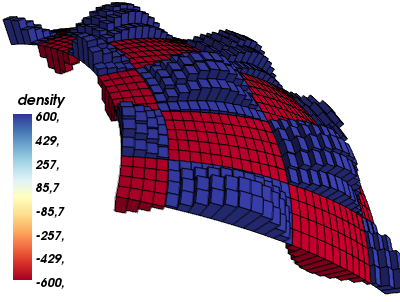

In [7]:
plot_result_3d(model, 'simple-synthetic-model.png')

For a sythetic test, I'll try to invert the sample mesh above from noise free data.

In [8]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


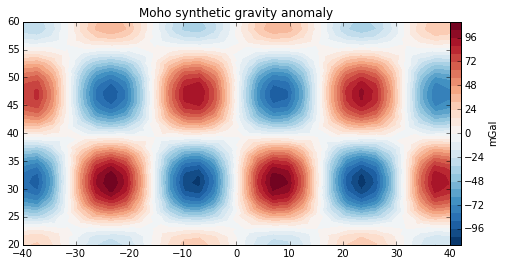

In [9]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

First, configure the inversion:

In [10]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
# Create the solver (using all available CPU cores)
solver = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu)
# Configure the optimization method
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('newton', initial=initial, tol=0.2)

In [11]:
# Run the inversion and time the computation
%time solver.fit()

CPU times: user 60.9 ms, sys: 35.2 ms, total: 96.1 ms
Wall time: 11.2 s


Plot the RMS per iteration to get an idea of the convergence of the method.

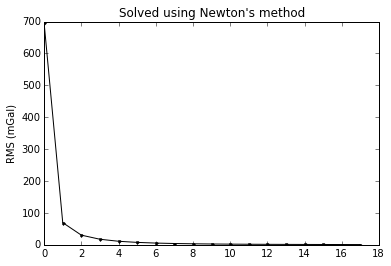

In [12]:
plt.figure()
ax1 = plt.subplot(111)
ax1.set_title('Solved using {}'.format(solver.stats_['method']))
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')

Plot the data misfit and residuals

In [13]:
predicted = solver.predicted()
residuals = solver.residuals()
moho = solver.estimate_

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


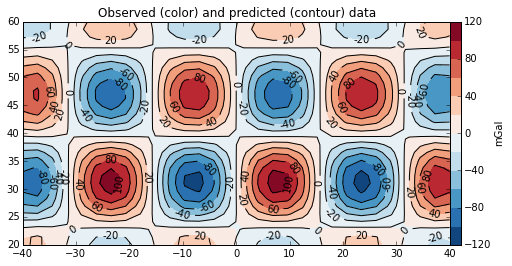

In [14]:
plt.figure(figsize=(9, 4))
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)
plt.title('Observed (color) and predicted (contour) data')

Mean: 0.0555101506957   std: 0.773523011807


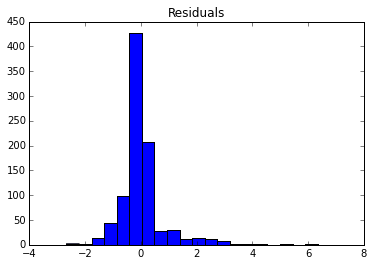

In [15]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

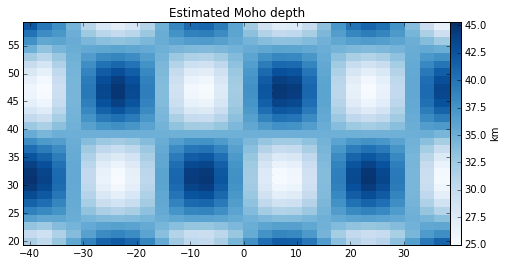

In [16]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues')
plt.colorbar(pad=0).set_label('km')

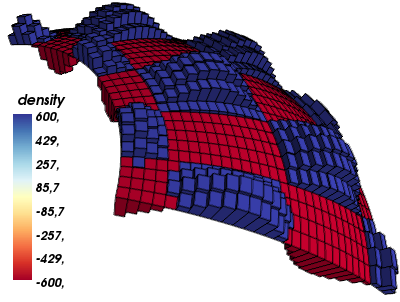

In [17]:
plot_result_3d(moho, 'mohoinv-example.png')

## Profile the inversion to see what is slow

I'll run the Python profiler (using the `%prun` IPython magic) to see where time is being spent in the inversion. I'll test the inversion by Gauss-Newton to see if solving the linear system has any impact on performance.

In [18]:
%prun -l 15 -q -T profiling.txt MohoGravityInvSpherical(lon, lat, h, gz, mesh).config('newton', initial=initial, tol=0.2).fit()
%cat profiling.txt

 
*** Profile printout saved to text file u'profiling.txt'. 
         2207800 function calls (2081415 primitive calls) in 20.561 seconds

   Ordered by: internal time
   List reduced from 1565 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18   17.715    0.984   20.501    1.139 tesseroid.py:288(_forward_model)
     2685    0.165    0.000    0.166    0.000 values.py:86(__init__)
    16392    0.148    0.000    0.366    0.000 context.py:139(resolve_data_type)
    16200    0.130    0.000    0.242    0.000 tesseroid_mesh.py:78(__getitem__)
    16320    0.117    0.000    0.117    0.000 __init__.py:501(cast)
        8    0.116    0.014    0.116    0.014 executionengine.py:93(finalize_object)
   348813    0.096    0.000    0.096    0.000 {isinstance}
        8    0.090    0.011    0.090    0.011 passmanagers.py:26(run)
    16200    0.080    0.000    0.102    0.000 mesher.py:527(__init__)
    59739    0.073    0.000    0.100    0.00

So it seems that all of the time is spent on forward modeling. This is not a bad thing because we can easily parallelize the forward modeling. The current inversion class does this by keeping a process pool openned and running the forward modeling on it. Keeping the pool is necessary to minimize the overhead of forking the processes evey time `predicted` is called.

## Inverting a Moho with laterally varying density

Lets see if the method for a Moho with a varying density contrast between crust and mantle.

In [19]:
model_varied = model.copy(deep=True)
vardensity = -300*utils.gaussian2d(lon, lat, 50, 30, x0=-20, y0=50, angle=-45) + 600
isabove = model_varied.relief > model_varied.reference
vardensity[isabove] *= -1
model_varied.props['density'] = vardensity

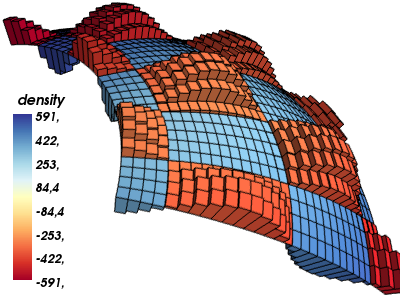

In [20]:
plot_result_3d(model_varied, 'moho-inv-example-vardens.png')

In [21]:
gz = tesseroid.gz(lon, lat, h, model_varied, njobs=ncpu)

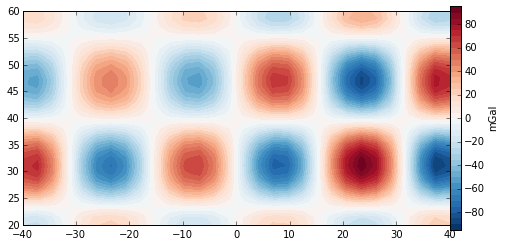

In [22]:
plt.figure(figsize=(9, 4))
plt.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

In [23]:
mesh = model_varied.copy(deep=True)
vardens = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu)
vardens.config('newton', initial=initial, tol=0.2, maxit=10) 
t0 = time.time()
vardens.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 5.79777312279 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


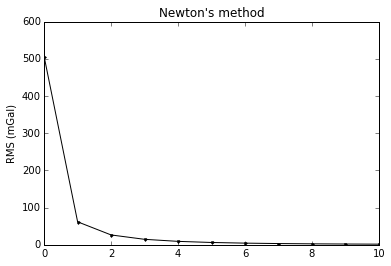

In [24]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(vardens.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(vardens.stats_['method'])

In [25]:
predicted = vardens.predicted()
residuals = vardens.residuals()
moho = vardens.estimate_

Mean: 0.178995618014   std: 1.70431357161


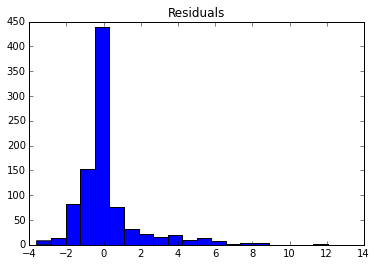

In [26]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

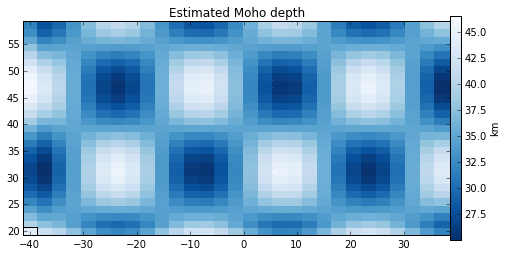

In [27]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
plt.colorbar(pad=0).set_label('km')
mpl.square(model[0].get_bounds()[:4])

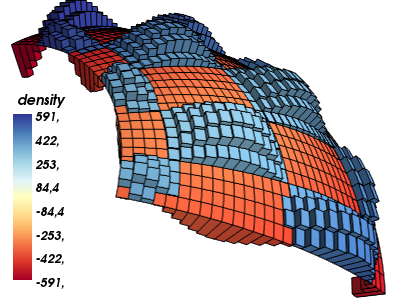

In [28]:
plot_result_3d(moho, 'moho-inv-example-vardens-result.png')